In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing relevant libraries
import pandas as pd # for manipulating data
import numpy as np # for performing numerical operations
import matplotlib.pyplot as plt # for data visualizationn
import seaborn as sns # for advanced data visualization
from sklearn.utils import resample # for undersampling
from sklearn.model_selection import train_test_split # for importing data splitting function from sklearn module
from sklearn.model_selection import GridSearchCV # for tuning hyperparameters using grid search
from sklearn.ensemble import RandomForestClassifier # for building Random Forest
import xgboost as xgb # for building XGBoost
from sklearn.neural_network import MLPClassifier # for building MLP
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # for calculating various evaluation metrics
from sklearn.metrics import roc_curve, auc # for analysing ROC and computing AUC
import joblib # for saving models in GoogleDrive (to prevent running the code again)
import shap # for model interpretation using SHAP
from lime.lime_tabular import LimeTabularExplainer # for model interpretation using LIME
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

**STEP 1: LOADING DATASET**

In [ ]:
# Reading dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/paysim.csv')

**STEP 2: PRELIMINARY DATAFRAME OPERATIONS**

In [ ]:
# Viewing shape of the dataset
df.shape

(6362620, 11)

In [ ]:
# Viewing first 5 observations of the dataset
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0

In [ ]:
# Viewing datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# Viewing summary statistics of continuous variables
df.describe()

# Insights: remove isFlaggedFraud (not meaningful)

step        amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00    1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05    9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07    3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [ ]:
# Viewing summary statistics of categorical variables
df.describe(include='object')

# Insights: remove nameOrig & nameDest (not meaningful)

type     nameOrig     nameDest
count    6362620      6362620      6362620
unique         5      6353307      2722362
top     CASH_OUT  C1902386530  C1286084959
freq     2237500            3          113

In [ ]:
# Rename the column 'oldbalanceOrg' to 'oldbalanceOrig'
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
df.head()

step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671           181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86  M1230701703             0.0             0.0        0               0

**STEP 3: EXPLORATORY DATA ANALYSIS**

In [ ]:
# Checking for missing values
df.isnull().sum()

# Insights: No missing values found

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**EDA - Categorical variables (IV)**

[Text(0, 0, '2237500'),
 Text(0, 0, '2151495'),
 Text(0, 0, '1399284'),
 Text(0, 0, '532909'),
 Text(0, 0, '41432')]

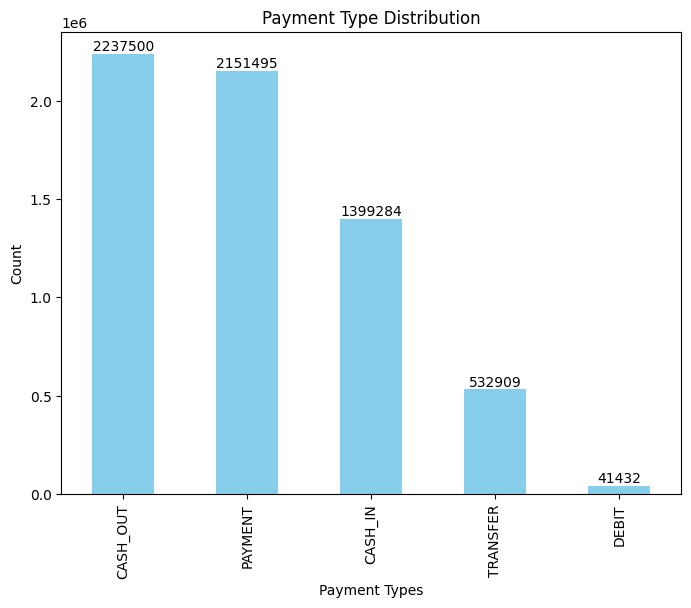

In [ ]:
# TRANSACTION TYPE
# Plotting a barplot for categorical variable, 'type'

type_count = df['type'].value_counts() # compute frequency of each unique value
plt.figure(figsize=(8, 6))
ax_type = type_count.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Types')
plt.ylabel('Count')
plt.title('Payment Type Distribution')
ax_type.bar_label(ax_type.containers[0], fontsize=10, color='black', labels=type_count.values)

<Figure size 800x600 with 0 Axes>

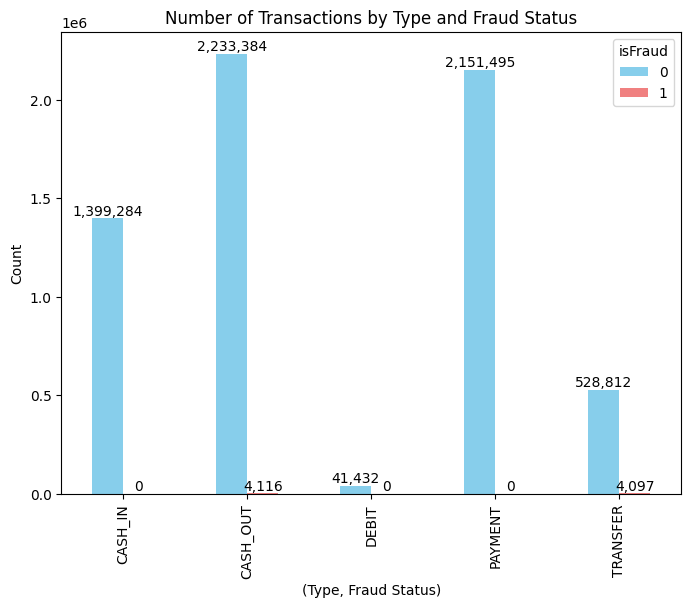

In [ ]:
# Plotting a barplot for categorical variable, 'type' by 'isFraud'
plt.figure(figsize=(8, 6))
ax_type2 = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0).plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.title("Number of Transactions by Type and Fraud Status")
plt.xlabel("(Type, Fraud Status)")
plt.ylabel("Count")
for p in ax_type2.patches:
    ax_type2.annotate(str(format(int(p.get_height()), ',d')), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom') # Labeling each bar with the count
plt.legend(title='isFraud', loc='upper right', labels=['0', '1'])
plt.show()

# Insights: Fraud transactions only occur in cash out and transfer transaction types

In [ ]:
# NAMEORIG & NAMEDEST
fraud = df[df["isFraud"] == 1]

fraudtransfer = fraud[fraud["type"] == "TRANSFER"]
fraudcashout = fraud[fraud["type"] == "CASH_OUT"]

fraudtransfer.nameDest.isin(fraudcashout.nameOrig).any()

# Insights: In the case of fraudulent transactions, the recipient accounts of transfer transactions are not at all used to cashout

False

In [ ]:
# Checking the destination of fraudulent transfer transactions
fraudtransfer['nameDest'].value_counts()

C553264065     1
C988859148     1
C1287650869    1
C922180689     1
C131895413     1
              ..
C776246900     1
C1234144009    1
C571016162     1
C1381364691    1
C2080388513    1
Name: nameDest, Length: 4097, dtype: int64

In [ ]:
# Checking the origin of fraudulent cash out transactions
fraudcashout['nameOrig'].value_counts()

# Insights: The origin and recipient names are therefore meaningless for modeling purposes and are removed

C840083671     1
C1055498407    1
C1886113938    1
C520336445     1
C463684846     1
              ..
C1641368956    1
C2120940829    1
C992121519     1
C1663597987    1
C1280323807    1
Name: nameOrig, Length: 4116, dtype: int64

In [ ]:
# ISFLAGGEDFRAUD
# Plotting a barplot for categorical variable, 'isFlaggedFraud' by 'isFraud'
plt.figure(figsize=(8, 6))
ax_isFlaggedFraud = df.groupby(['isFlaggedFraud', 'isFraud']).size().unstack(fill_value=0).plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.title("Number of Flagged Transactions by Fraud Status")
plt.xlabel("Flagged Status")
plt.ylabel("Count")
for p in ax_isFlaggedFraud.patches:
    ax_isFlaggedFraud.annotate(str(format(int(p.get_height()), ',d')), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom') # Labeling each bar with the count
plt.legend(title='isFraud', loc='upper right', labels=['0', '1'])
plt.show()

# Insights: Only 16 transactions out of 8213 (8197 + 16) total fraudulent transactions are flagged as fraud

<Figure size 800x600 with 0 Axes>

**EDA - Dependent variable**

In [ ]:
# Finding unique values of 'isFraud' column (Dependent variable)
unique_values_isFraud = df['isFraud'].unique()
print("Unique values for 'isFraud':", unique_values_isFraud)

Unique values for 'isFraud': [0 1]


[Text(0, 0, '6354407'), Text(0, 0, '8213')]

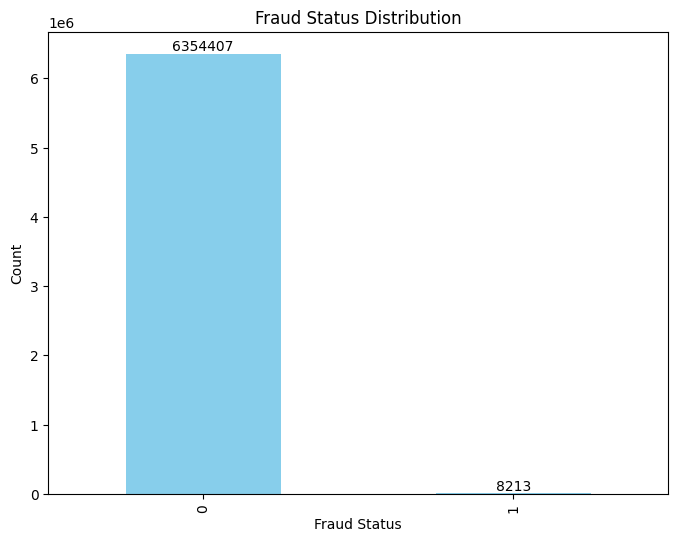

In [ ]:
# ISFRAUD
# Checking class imbalance in 'isFraud' column

fraud_count = df['isFraud'].value_counts() # frequency count of each unique value
plt.figure(figsize=(8, 6))
ax_fraud = fraud_count.plot(kind='bar', color='skyblue')
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud Status Distribution')
ax_fraud.bar_label(ax_fraud.containers[0], fontsize=10, color='black', labels=fraud_count.values)

In [ ]:
fraud_count = df['isFraud'].value_counts()
fraud_count

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
fraud_percentage = df['isFraud'].value_counts(normalize=True) * 100
fraud_percentage

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

**EDA - Continuous variables (IV)**

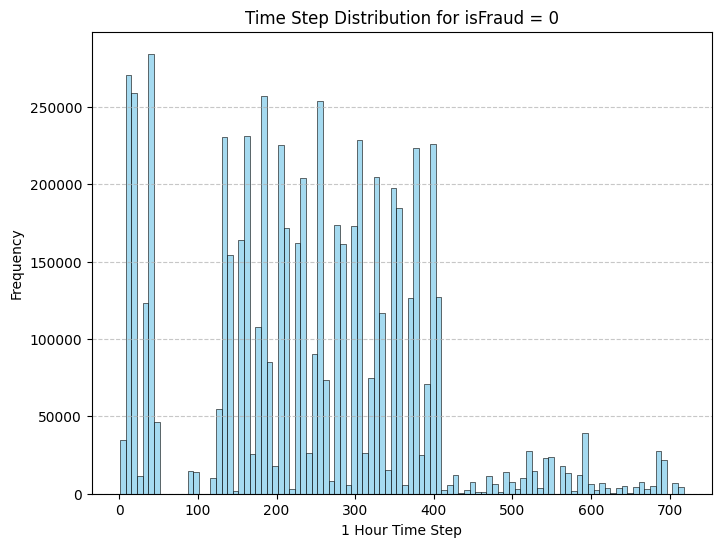

In [ ]:
# STEP
# Time Step Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_step_0 = sns.histplot(data=df_isFraud_0, x='step', bins=100, color='skyblue')
plt.xlabel('1 Hour Time Step')
plt.ylabel('Frequency')
plt.title('Time Step Distribution for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Time Step Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_step_1 = sns.histplot(data=df_isFraud_1, x='step', bins=100, color='pink')
plt.xlabel('1 Hour Time Step')
plt.ylabel('Frequency')
plt.title('Time Step Distribution for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights:
# 1. The distribution of fraudulent transactions is uniform across all time steps
# 2. Non-fraudulent transactions peak at certain time steps around the 0th and 50th time step and the 110th and 410th time step

In [ ]:
# AMOUNT
# Amount Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_amnt_0 = sns.histplot(data=df_isFraud_0, x='amount', bins=100, color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Amount Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_amnt_1 = sns.histplot(data=df_isFraud_1, x='amount', bins=100, color='pink')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights: Higher likelihood of fraud at higher transaction amounts

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'amount', data = df, palette="viridis")
plt.title('Transaction Amount by Fraud Status', fontweight="bold", size=12)

# Insights: Median amount of fraudulent transactions is higher than genuine transactions

Text(0.5, 1.0, 'Transaction Amount by Fraud Status')

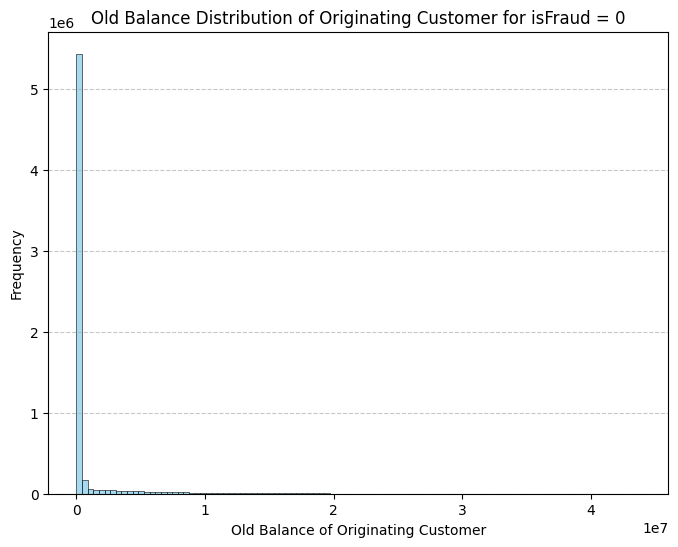

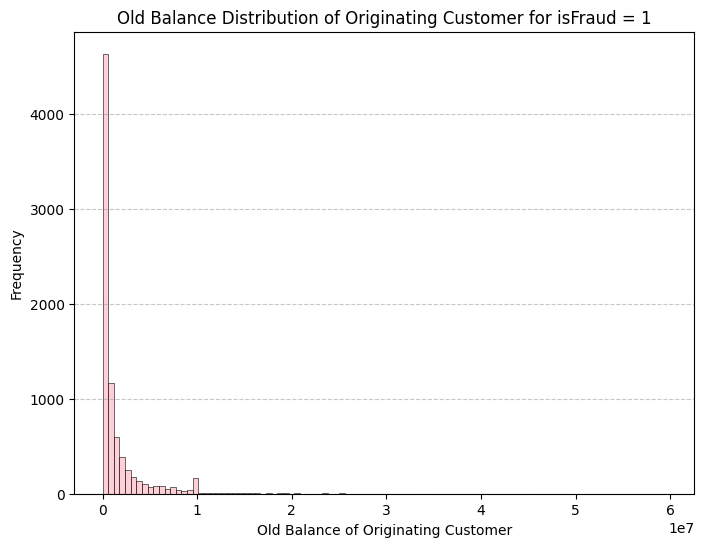

In [ ]:
# OLDBALANCEORIG
# oldbalanceOrig Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_oldOrig_0 = sns.histplot(data=df_isFraud_0, x='oldbalanceOrig', bins=100, color='skyblue')
plt.xlabel('Old Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Originating Customer for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# oldbalanceOrig Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_oldOrig_1 = sns.histplot(data=df_isFraud_1, x='oldbalanceOrig', bins=100, color='pink')
plt.xlabel('Old Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Originating Customer for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights: Higher likelihood of fraud when old balance of originating customer is higher

Text(0.5, 1.0, 'Old Balance of Originating Customer by Fraud Status')

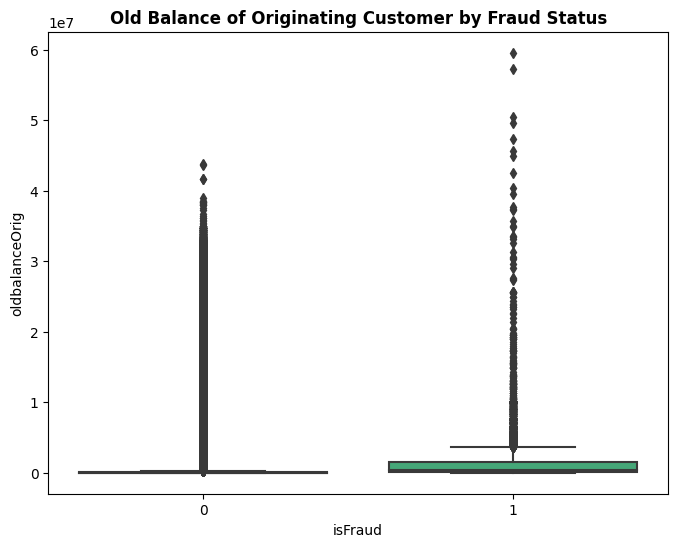

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'oldbalanceOrig', data = df, palette="viridis")
plt.title('Old Balance of Originating Customer by Fraud Status', fontweight="bold", size=12)

# Insights: Old balance of originating customer in fraudulent transactions is higher than genuine transactions

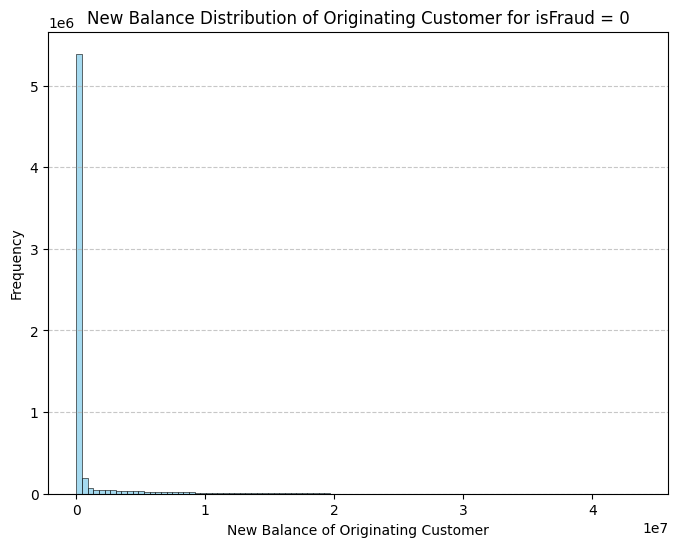

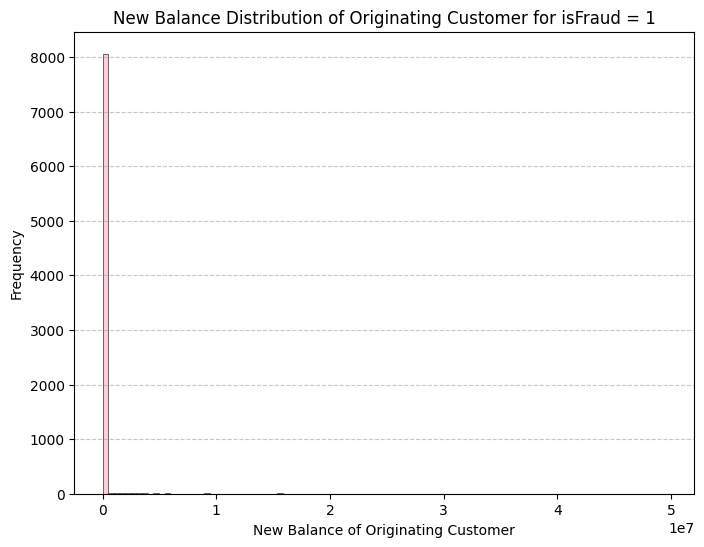

In [ ]:
# NEWBALANCEORIG
# newbalanceOrig Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_newOrig_0 = sns.histplot(data=df_isFraud_0, x='newbalanceOrig', bins=100, color='skyblue')
plt.xlabel('New Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Originating Customer for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# newbalanceOrig Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_newOrig_1 = sns.histplot(data=df_isFraud_1, x='newbalanceOrig', bins=100, color='pink')
plt.xlabel('New Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Originating Customer for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'New Balance of Originating Customer by Fraud Status')

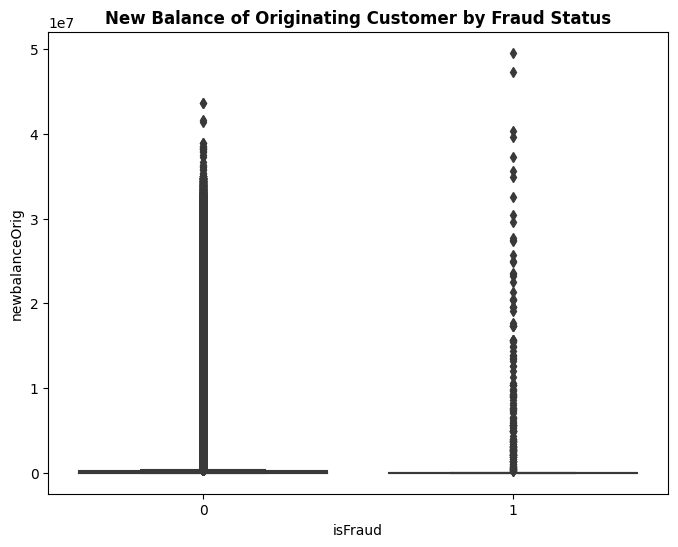

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'newbalanceOrig', data = df, palette="viridis")
plt.title('New Balance of Originating Customer by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of new balance of originating customer does not really distinguish between fraudulent and genuine transactions

In [ ]:
# OLDBALANCEDEST
# oldbalanceDest Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_oldDest_0 = sns.histplot(data=df_isFraud_0, x='oldbalanceDest', bins=100, color='skyblue')
plt.xlabel('Old Balance of Recipient')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Recipient for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# oldbalanceDest Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_oldDest_1 = sns.histplot(data=df_isFraud_1, x='oldbalanceDest', bins=100, color='pink')
plt.xlabel('Old Balance of Recipient')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Recipient for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = df, palette="viridis")
plt.title('Old Balance of Recipient by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of old balance of recipient customer does not really distinguish between fraudulent and genuine transactions

Text(0.5, 1.0, 'Old Balance of Recipient by Fraud Status')

In [ ]:
# NEWBALANCEDEST
# newbalanceDest Distribution by Fraud Status = 0
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_newDest_0 = sns.histplot(data=df_isFraud_0, x='newbalanceDest', bins=100, color='skyblue')
plt.xlabel('New Balance of Recipient')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Recipient for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# newbalanceDest Distribution by Fraud Status = 1
df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_newDest_1 = sns.histplot(data=df_isFraud_1, x='newbalanceDest', bins=100, color='pink')
plt.xlabel('New Balance of Recipient')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Recipient for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'New Balance of Recipient by Fraud Status')

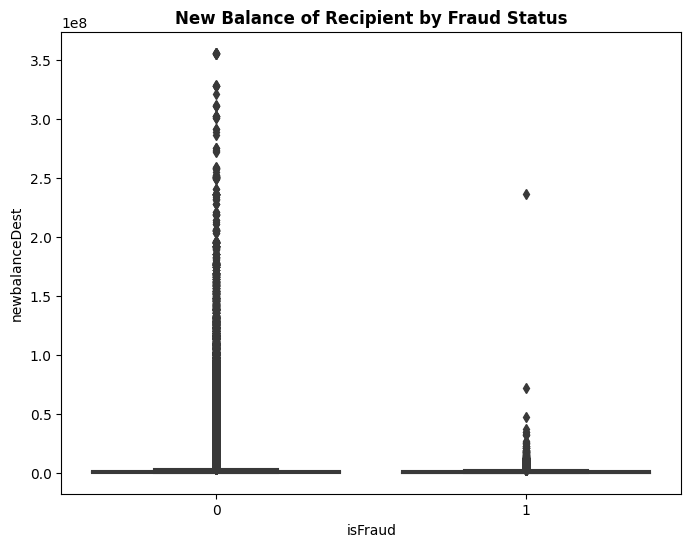

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'newbalanceDest', data = df, palette="viridis")
plt.title('New Balance of Recipient by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of new balance of recipient customer does not really distinguish between fraudulent and genuine transactions

In [ ]:
# Checking balances before and after transactions

# Count of observations where there is a discrepancy between calculated new balance and recorded new balance in originator account
error_orig_bal = sum(df["oldbalanceOrig"] - df["amount"] != df["newbalanceOrig"])
# Count of observations where there is a discrepancy between calculated new balance and recorded new balance in recipient account
error_dest_bal = sum(df["oldbalanceDest"] + df["amount"] != df["newbalanceDest"])
print("Percentage of observations where errors in originator account balances are observed: ", 100*round(error_orig_bal/len(df),2))
print("Percentage of observations where errors in recipient account balances are observed: ", 100*round(error_dest_bal/len(df),2))

Percentage of observations where errors in originator account balances are observed:  85.0
Percentage of observations where errors in recipient account balances are observed:  74.0


In [ ]:
# Plotting correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm') # annot=True displays numbers in each cell
plt.title('Correlation Heatmap')
plt.show()

<ipython-input-16-96eed6879fd0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


**STEP 4: DATA CLEANING**

In [ ]:
# Dropping irrelevant columns
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df.drop(columns=columns_to_drop, inplace=True) # inplace = True will modify existing dataframe

# Information of new dataframe with dropped columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [ ]:
# Removing observations in which transaction type is 'CASH_IN', 'DEBIT' & 'PAYMENT'
df = df[~df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT'])]

In [ ]:
df.shape

(2770409, 8)

**STEP 5 - FEATURE ENGINEERING**

In [ ]:
# Feature engineering
df['errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrig']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

**STEP 6: ENCODING**

In [ ]:
# One hot encoding 'type' column
df_encoded = pd.get_dummies(df, columns=['type'])
df_encoded.head()

step     amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
2      1     181.00           181.0             0.0             0.0            0.00        1              0.00             181.0              0              1
3      1     181.00           181.0             0.0         21182.0            0.00        1              0.00           21363.0              1              0
15     1  229133.94         15325.0             0.0          5083.0        51513.44        0         213808.94          182703.5              1              0
19     1  215310.30           705.0             0.0         22425.0            0.00        0         214605.30          237735.3              0              1
24     1  311685.89         10835.0             0.0          6267.0      2719172.89        0         300850.89        -2401220.0              0              1

**STEP 7: UNDERSAMPLING TO SOLVE CLASS IMBALANCE**

In [ ]:
# Undersampling to address class imbalance

majority_class = df_encoded[df_encoded['isFraud'] == 0] # splitting data into majority class
minority_class = df_encoded[df_encoded['isFraud'] == 1] # splitting data into minority class
min_samples = len(minority_class) # sample size of minority class
majority_undersampled = resample(majority_class, n_samples=min_samples, replace=False, random_state=60) # random undersampling on majority class
df_balanced = pd.concat([majority_undersampled, minority_class]) # combine

[Text(0, 0, '8213'), Text(0, 0, '8213')]

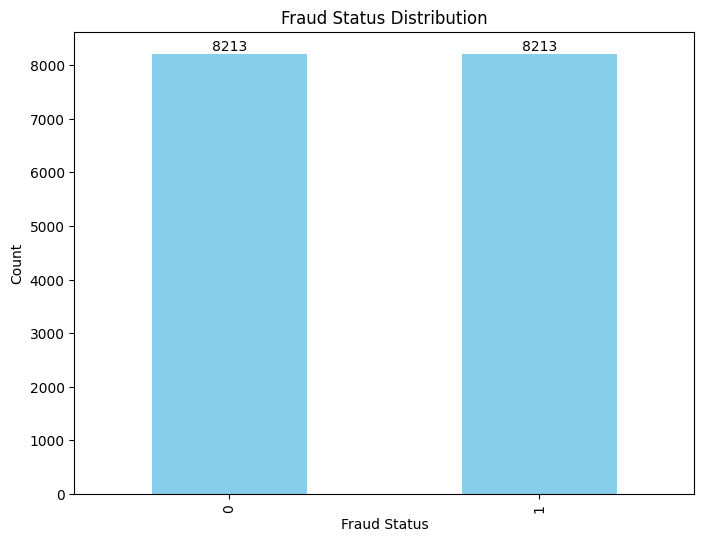

In [ ]:
# Visualizing 'isFraud' column post undersampling

fraud_count_balanced = df_balanced['isFraud'].value_counts() # frequency count of each unique value
plt.figure(figsize=(8, 6))
ax_fraud_balanced = fraud_count_balanced.plot(kind='bar', color='skyblue')
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud Status Distribution')
ax_fraud_balanced.bar_label(ax_fraud_balanced.containers[0], fontsize=10, color='black', labels=fraud_count_balanced.values)

In [ ]:
fraud_count_balanced = df_balanced['isFraud'].value_counts()
print("Fraud Status Count in the Balanced Dataset:")
print (fraud_count_balanced)

fraud_percentage_balanced = df_balanced['isFraud'].value_counts(normalize=True) * 100
print("Fraud Status Percentage in the Balanced Dataset:")
print(fraud_percentage_balanced)

Fraud Status Count in the Balanced Dataset:
0    8213
1    8213
Name: isFraud, dtype: int64
Fraud Status Percentage in the Balanced Dataset:
0    50.0
1    50.0
Name: isFraud, dtype: float64


**STEP 8: TRAIN TEST SPLIT**

In [ ]:
# Train test split

x = df_balanced.drop('isFraud', axis=1)  # Store independent variables in x, drop 'isFraud' column
y = df_balanced['isFraud']  # Store target variable
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=60, stratify=y) # 70:30 ratio of train to test, stratify target variable to maintain proportion of 0 and 1 class

In [ ]:
x_train.head()

step     amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
1511330   148  394886.13       394886.13             0.0             0.0            0.00              0.00         394886.13              0              1
4845867   347  158389.96        36082.00             0.0             0.0       158389.96         122307.96              0.00              1              0
6362525   735  123146.28       123146.28             0.0             0.0       123146.28              0.00              0.00              1              0
4784096   336    9207.38         9207.38             0.0             0.0            0.00              0.00           9207.38              0              1
6274160   637  447474.67       447474.67             0.0             0.0            0.00              0.00         447474.67              0              1

In [ ]:
y_train.head()

1511330    1
4845867    0
6362525    1
4784096    1
6274160    1
Name: isFraud, dtype: int64

In [ ]:
# Checking proportion of class 0 and 1 post train test split

fraud_count_train_split = y_train.value_counts()
print("Fraud Status Count in Train Data:")
print (fraud_count_train_split)

fraud_count_test_split = y_test.value_counts()
print("Fraud Status Count in Test Data:")
print (fraud_count_test_split)

Fraud Status Count in Train Data:
1    5749
0    5749
Name: isFraud, dtype: int64
Fraud Status Count in Test Data:
0    2464
1    2464
Name: isFraud, dtype: int64


**STEP 9: MODELING**

*MODEL A1: Random Forest (baseline)*

In [ ]:
# Initializing Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=10, n_jobs=-1)

# Training the classifier on train set
rf.fit(x_train, y_train)

# Making predictions on train & test set
ytra_pred_rf = rf.predict(x_train)
y_pred_rf = rf.predict(x_test)

# Evaluating the model
train_accuracy_rf = accuracy_score(y_train, ytra_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
train_class_report_rf = classification_report(y_train, ytra_pred_rf, digits=4) # digits=4 for generating scores in 4 decimal places
class_report_rf = classification_report(y_test, y_pred_rf, digits=4)

# Printing accuracy & classification report
print(f'Train Accuracy: {train_accuracy_rf:.4f}')
print(f'Test Accuracy: {accuracy_rf:.4f}')
print('Classification Report of Train Set Predictions using Random Forest Model:')
print(train_class_report_rf)
print('Classification Report of Test Set Predictions using Random Forest Model:')
print(class_report_rf)

Train Accuracy: 0.9996
Test Accuracy: 0.9982
Classification Report of Train Set Predictions using Random Forest Model:
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996      5749
           1     0.9998    0.9993    0.9996      5749

    accuracy                         0.9996     11498
   macro avg     0.9996    0.9996    0.9996     11498
weighted avg     0.9996    0.9996    0.9996     11498

Classification Report of Test Set Predictions using Random Forest Model:
              precision    recall  f1-score   support

           0     0.9972    0.9992    0.9982      2464
           1     0.9992    0.9972    0.9982      2464

    accuracy                         0.9982      4928
   macro avg     0.9982    0.9982    0.9982      4928
weighted avg     0.9982    0.9982    0.9982      4928



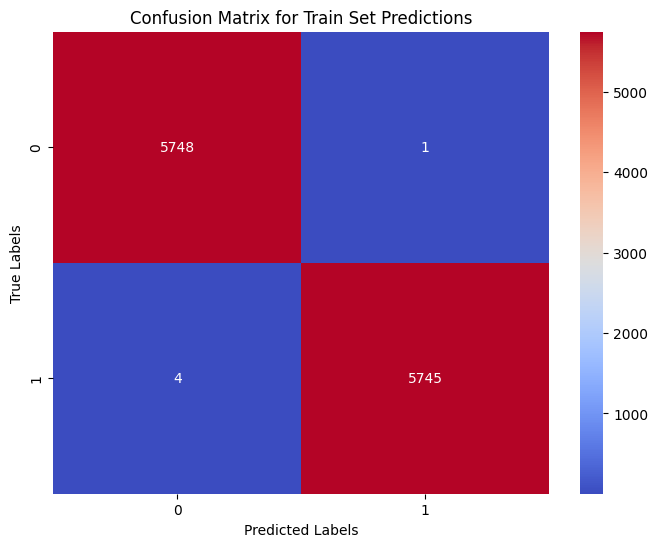

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_rf = confusion_matrix(y_train, ytra_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_rf, annot=True, fmt='d', cmap='coolwarm') # annot=True displays numbers in each cell, fmt='d' passes values as a decimal
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# For plotting the multiple ROC curve

# Computing FPR and TPR of test set predictions
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_pred_rf)

# Computing AUC of test set predictions
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(rf, '/content/drive/My Drive/Colab Notebooks/CP2/rf_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
# loaded_rf = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/rf_model.pkl')

In [ ]:
# Accessing the hyperparameters of the baseline RF model
rf_params = rf.get_params()
print(rf_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


*MODEL A2: Tuned Random Forest*


In [ ]:
# Defining hyperparameter grid
param_grid_rf = {
    'n_estimators': [30,50,150,200],
    'max_depth': [2,10,20,30]
}

# Initializing RF model
rf_tuned = RandomForestClassifier(random_state=42)

# Initializing GridSearchCV with RF and hyperparameter grid
grid_search_rf = GridSearchCV(estimator=rf_tuned, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Performing the grid search on train data
grid_search_rf.fit(x_train, y_train)

# Getting the best estimator from the grid search
best_rf = grid_search_rf.best_estimator_

# Making predictions on the train & test data using the best estimator
ytra_pred_rf_tuned = best_rf.predict(x_train)
y_pred_rf_tuned = best_rf.predict(x_test)

# Evaluating the model
train_accuracy_rf_tuned = accuracy_score(y_train, ytra_pred_rf_tuned)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
train_class_report_rf_tuned = classification_report(y_train, ytra_pred_rf_tuned, digits=4)
class_report_rf_tuned = classification_report(y_test, y_pred_rf_tuned, digits=4)

# Printing accuracy & classification report
print(f'Best Hyperparameters for Random Forest Model: {grid_search_rf.best_params_}')
print(f'Train Accuracy: {train_accuracy_rf_tuned:.4f}')
print(f'Test Accuracy: {accuracy_rf_tuned:.4f}')
print('Classification Report of Train Set Predictions using Tuned Random Forest Model:')
print(train_class_report_rf_tuned)
print('Classification Report of Test Set Predictions using Tuned Random Forest Model:')
print(class_report_rf_tuned)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters for Random Forest Model: {'max_depth': 20, 'n_estimators': 30}
Train Accuracy: 0.9998
Test Accuracy: 0.9986
Classification Report of Train Set Predictions using Tuned Random Forest Model:
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998      5749
           1     0.9998    0.9998    0.9998      5749

    accuracy                         0.9998     11498
   macro avg     0.9998    0.9998    0.9998     11498
weighted avg     0.9998    0.9998    0.9998     11498

Classification Report of Test Set Predictions using Tuned Random Forest Model:
              precision    recall  f1-score   support

           0     0.9972    1.0000    0.9986      2464
           1     1.0000    0.9972    0.9986      2464

    accuracy                         0.9986      4928
   macro avg     0.9986    0.9986    0.9986      4928
weighted avg     0.9986    0.9986    0.9986      492

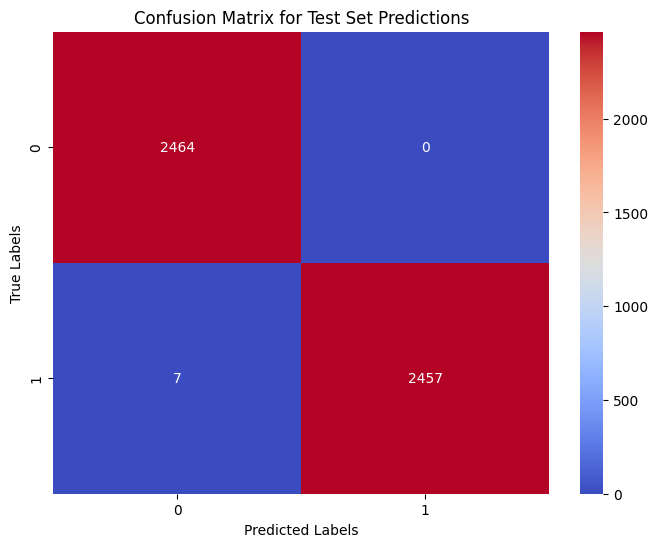

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_rf_tuned = confusion_matrix(y_train, ytra_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_rf_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(best_rf, '/content/drive/My Drive/Colab Notebooks/CP2/best_rf_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
loaded_best_rf = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/best_rf_model.pkl')

In [ ]:
# For plotting the multiple ROC curve

# Making predictions on test data using the best estimator
y_pred_loaded_rf_tuned = loaded_best_rf.predict(x_test)

# Computing FPR and TPR of test set predictions
fpr_loaded_rf_tuned, tpr_loaded_rf_tuned, _ = roc_curve(y_test, y_pred_loaded_rf_tuned)

# Computing AUC of test set predictions
roc_auc_loaded_rf_tuned = auc(fpr_loaded_rf_tuned, tpr_loaded_rf_tuned)

In [ ]:
rf_tuned_params = best_rf.get_params()
print(rf_tuned_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


*MODEL B1: XGBoost*

In [ ]:
# Initializing XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', # binary:logistic is for binary classification
                              random_state=42,
                              n_estimators=100,
                              max_depth=5,
                              learning_rate=0.1,
                              min_child_weight=1,
                              gamma=0,
                              subsample=1.0,
                              colsample_bytree=1.0)

# Training the classifier on train set
xgb_model.fit(x_train, y_train)

# Making predictions on train & test set
ytra_pred_xgb = xgb_model.predict(x_train)
y_pred_xgb = xgb_model.predict(x_test)

# Evaluating the model
train_accuracy_xgb = accuracy_score(y_train, ytra_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
train_class_report_xgb = classification_report(y_train, ytra_pred_xgb, digits=4)
class_report_xgb = classification_report(y_test, y_pred_xgb, digits=4)

# Printing evaluation metrics
print(f'Train Accuracy: {train_accuracy_xgb:.4f}')
print(f'Test Accuracy: {accuracy_xgb:.4f}')
print('Classification Report of Train Set Predictions using XGBoost Model:')
print(train_class_report_xgb)
print('Classification Report of Test Set Predictions using XGBoost Model:')
print(class_report_xgb)

Train Accuracy: 0.9989
Test Accuracy: 0.9982
Classification Report of Train Set Predictions using XGBoost Model:
              precision    recall  f1-score   support

           0     0.9981    0.9997    0.9989      5749
           1     0.9997    0.9981    0.9989      5749

    accuracy                         0.9989     11498
   macro avg     0.9989    0.9989    0.9989     11498
weighted avg     0.9989    0.9989    0.9989     11498

Classification Report of Test Set Predictions using XGBoost Model:
              precision    recall  f1-score   support

           0     0.9976    0.9988    0.9982      2464
           1     0.9988    0.9976    0.9982      2464

    accuracy                         0.9982      4928
   macro avg     0.9982    0.9982    0.9982      4928
weighted avg     0.9982    0.9982    0.9982      4928



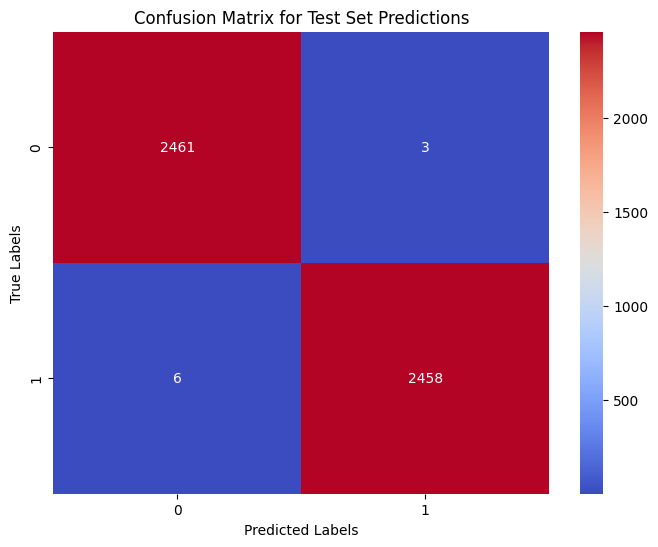

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_xgb = confusion_matrix(y_train, ytra_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_xgb, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# For plotting the multiple ROC curve

# Computing FPR and TPR of test set predictions
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_pred_xgb)

# Computing AUC of test set predictions
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(xgb_model, '/content/drive/My Drive/Colab Notebooks/CP2/xgb_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
# loaded_xgb = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/xgb_model.pkl')

In [ ]:
xgb_model_params = xgb_model.get_params()
print(xgb_model_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


*MODEL B2: Tuned XGBoost*

In [ ]:
# Defining hyperparameter grid
param_grid_xgb = {
   'n_estimators': [50, 100, 150, 200],
   'max_depth': [5, 10, 20],
   'min_child_weight': [3, 5, 7],
   'learning_rate': [0.1, 0.2, 0.3],
   'gamma': [0, 3, 5],
   'subsample': [1.0],
   'colsample_bytree': [1.0]
}

# Initializing XGBoost model
xgb_tuned = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Initializing GridSearchCV with XGBoost and hyperparameter grid
grid_search_xgb = GridSearchCV(estimator=xgb_tuned, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)

# Performing the grid search on train data
grid_search_xgb.fit(x_train, y_train)

# Getting the best estimator from the grid search
best_xgb = grid_search_xgb.best_estimator_

# Making predictions on train & test data using the best estimator
ytra_pred_xgb_tuned = best_xgb.predict(x_train)
y_pred_xgb_tuned = best_xgb.predict(x_test)

# Evaluating the model
train_accuracy_xgb_tuned = accuracy_score(y_train, ytra_pred_xgb_tuned)
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
train_class_report_xgb_tuned = classification_report(y_train, ytra_pred_xgb_tuned, digits=4)
class_report_xgb_tuned = classification_report(y_test, y_pred_xgb_tuned, digits=4)

# Printing evaluation metrics and best hyperparameters
print(f'Best Hyperparameters for XGBoost Model: {grid_search_xgb.best_params_}')
print(f'Train Accuracy: {train_accuracy_xgb_tuned:.4f}')
print(f'Test Accuracy: {accuracy_xgb_tuned:.4f}')
print('Classification Report of Train Set Predictions using Tuned XGBoost Model:')
print(train_class_report_xgb_tuned)
print('Classification Report of Test Set Predictions using Tuned XGBoost Model:')
print(class_report_xgb_tuned)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters for XGBoost Model: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 200, 'subsample': 1.0}
Train Accuracy: 0.9987
Test Accuracy: 0.9988
Classification Report of Train Set Predictions using Tuned XGBoost Model:
              precision    recall  f1-score   support

           0     0.9979    0.9995    0.9987      5749
           1     0.9995    0.9979    0.9987      5749

    accuracy                         0.9987     11498
   macro avg     0.9987    0.9987    0.9987     11498
weighted avg     0.9987    0.9987    0.9987     11498

Classification Report of Test Set Predictions using Tuned XGBoost Model:
              precision    recall  f1-score   support

           0     0.9980    0.9996    0.9988      2464
           1     0.9996    0.9980    0.9988      2464

    accuracy                         0.9988      4928
   macro avg     0.99

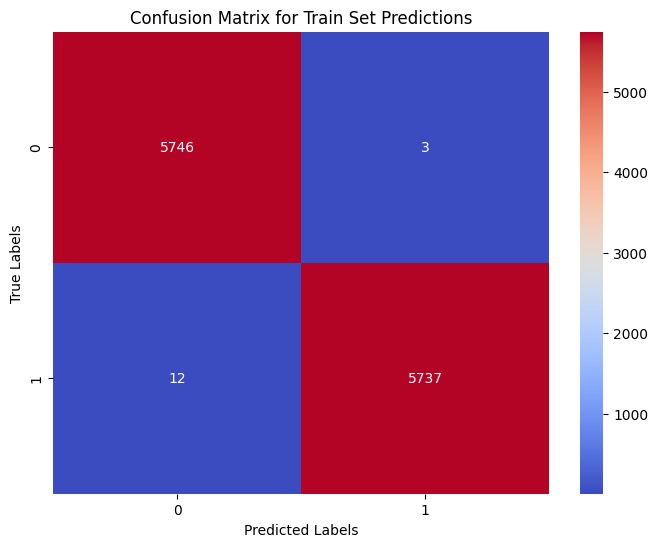

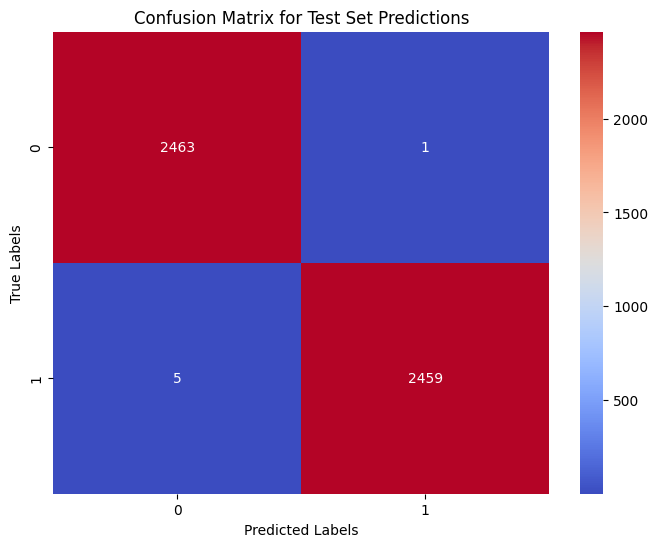

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_xgb_tuned = confusion_matrix(y_train, ytra_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(best_xgb, '/content/drive/My Drive/Colab Notebooks/CP2/best_xgb_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
loaded_best_xgb = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/best_xgb_model.pkl')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:27:37] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [ ]:
# For plotting the multiple ROC curve

# Making predictions on test data using the best estimator
y_pred_loaded_xgb_tuned = loaded_best_xgb.predict(x_test)

# Computing FPR and TPR of test set predictions
fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned, _ = roc_curve(y_test, y_pred_loaded_xgb_tuned)

# Computing AUC of test set predictions
roc_auc_loaded_xgb_tuned = auc(fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned)

In [ ]:
# Creating a feature importance plot for the best model as a benchmark for XAI methods
xgb.plot_importance(loaded_best_xgb, importance_type='gain') # gain measures the average improvement in loss brought by a feature
plt.title('Feature Importance Plot for Tuned XGBoost Model')
plt.show()

In [ ]:
xgb_tuned_params = best_xgb.get_params()
print(xgb_tuned_params)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


*MODEL C1: MULTILAYER PERCEPTRON*

In [ ]:
# Initializing MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(50,25), random_state=42)

# Training the classifier on train set
mlp.fit(x_train, y_train)

# Making predictions on train & test set
ytra_pred_mlp = mlp.predict(x_train)
y_pred_mlp = mlp.predict(x_test)

# Evaluating the model
train_accuracy_mlp = accuracy_score(y_train, ytra_pred_mlp)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
train_class_report_mlp = classification_report(y_train, ytra_pred_mlp, digits=4)
class_report_mlp = classification_report(y_test, y_pred_mlp, digits=4)

# Printing evaluation metrics
print(f'Train Accuracy: {train_accuracy_mlp:.4f}')
print(f'Accuracy: {accuracy_mlp:.4f}')
print('Classification Report of Train Set Predictions using MLP model:')
print(train_class_report_mlp)
print('Classification Report of Test Set Predictions using MLP model:')
print(class_report_mlp)

Train Accuracy: 0.9787
Accuracy: 0.9771
Classification Report of Train Set Predictions using MLP model:
              precision    recall  f1-score   support

           0     0.9727    0.9850    0.9788      5749
           1     0.9848    0.9723    0.9786      5749

    accuracy                         0.9787     11498
   macro avg     0.9788    0.9787    0.9787     11498
weighted avg     0.9788    0.9787    0.9787     11498

Classification Report of Test Set Predictions using MLP model:
              precision    recall  f1-score   support

           0     0.9749    0.9793    0.9771      2464
           1     0.9792    0.9748    0.9770      2464

    accuracy                         0.9771      4928
   macro avg     0.9771    0.9771    0.9771      4928
weighted avg     0.9771    0.9771    0.9771      4928



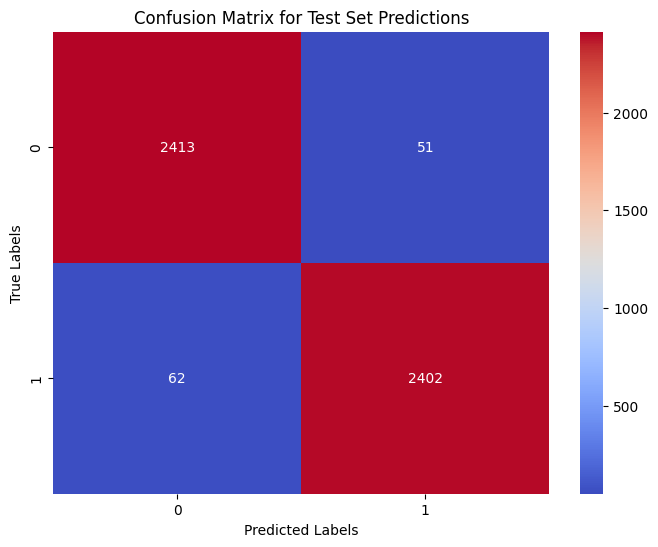

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_mlp = confusion_matrix(y_train, ytra_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_mlp, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# For plotting the multiple ROC curve

# Computing FPR and TPR of test set predictions
fpr_test_mlp, tpr_test_mlp, _ = roc_curve(y_test, y_pred_mlp)

# Computing AUC of test set predictions
roc_auc_test_mlp = auc(fpr_test_mlp, tpr_test_mlp)

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(mlp, '/content/drive/My Drive/Colab Notebooks/CP2/mlp_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
# loaded_mlp = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/mlp_model.pkl')

In [ ]:
mlp_params = mlp.get_params()
print(mlp_params)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


*Model C2: Tuned MLP*

In [ ]:
# Defining hyperparameter grid
param_grid_mlp = {
    'hidden_layer_sizes': [(50,25), (100, 50), (200, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [200, 500, 1000]
}

# Initializing MLP classifier
mlp_tuned = MLPClassifier(random_state=42)

# Initializing GridSearchCV with MLP and hyperparameter grid
grid_search_mlp = GridSearchCV(estimator=mlp_tuned, param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)

# Performing the grid search on train data
grid_search_mlp.fit(x_train, y_train)

# Getting the best estimator from grid search
best_mlp = grid_search_mlp.best_estimator_

# Making predictions on train and test data using the best estimator
ytra_pred_mlp_tuned = best_mlp.predict(x_train)
y_pred_mlp_tuned = best_mlp.predict(x_test)

# Evaluating the model
train_accuracy_mlp_tuned = accuracy_score(y_train, ytra_pred_mlp_tuned)
accuracy_mlp_tuned = accuracy_score(y_test, y_pred_mlp_tuned)
train_class_report_mlp_tuned = classification_report(y_train, ytra_pred_mlp_tuned, digits=4)
class_report_mlp_tuned = classification_report(y_test, y_pred_mlp_tuned, digits=4)

# Printing evaluation metrics and best hyperparameters
print(f'Best Hyperparameters for MLP classifier: {grid_search_mlp.best_params_}')
print(f'Train Accuracy: {train_accuracy_mlp_tuned:.4f}')
print(f'Test Accuracy: {accuracy_mlp_tuned:.4f}')
print('Classification Report of Train Set Predicitions using MLP classifier:')
print(train_class_report_mlp_tuned)
print('Classification Report of Test Set Predicitions using MLP classifier:')
print(class_report_mlp_tuned)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters for MLP classifier: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'max_iter': 200, 'solver': 'adam'}
Train Accuracy: 0.9828
Test Accuracy: 0.9813
Classification Report of Train Set Predicitions using MLP classifier:
              precision    recall  f1-score   support

           0     0.9912    0.9743    0.9826      5749
           1     0.9747    0.9913    0.9829      5749

    accuracy                         0.9828     11498
   macro avg     0.9829    0.9828    0.9828     11498
weighted avg     0.9829    0.9828    0.9828     11498

Classification Report of Test Set Predicitions using MLP classifier:
              precision    recall  f1-score   support

           0     0.9917    0.9708    0.9811      2464
           1     0.9714    0.9919    0.9815      2464

    accuracy                         0.9813      4928
   macro avg     0.9815    0.9813    0.9813      4928
weighted avg     0.9815 

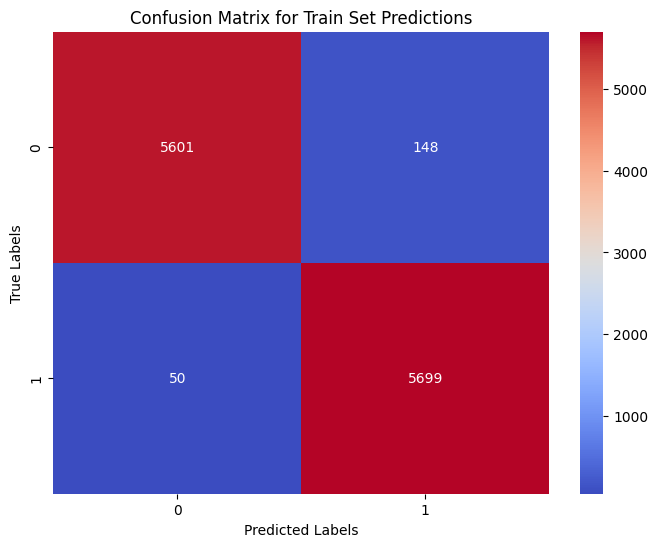

In [ ]:
# Creating a confusion matrix heatmap
train_conf_matrix_mlp_tuned = confusion_matrix(y_train, ytra_pred_mlp_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_mlp_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_mlp_tuned = confusion_matrix(y_test, y_pred_mlp_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [ ]:
# Saving the best tuned model to a file
# joblib.dump(best_mlp, '/content/drive/My Drive/Colab Notebooks/CP2/best_mlp_model.pkl')

# Loading the model from Google Drive (to avoid retraining it)
loaded_best_mlp = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/best_mlp_model.pkl')

In [ ]:
# For plotting the multiple ROC curve

# Making predictions on test data using the best estimator
y_pred_loaded_mlp_tuned = loaded_best_mlp.predict(x_test)

# Computing FPR and TPR of test set predictions
fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned, _ = roc_curve(y_test, y_pred_loaded_mlp_tuned)

# Computing AUC of test set predictions
roc_auc_loaded_mlp_tuned = auc(fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned)

In [ ]:
mlp_tuned_params = best_mlp.get_params()
print(mlp_tuned_params)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


*MULTIPLE ROC CURVE FOR MODEL COMPARISON*

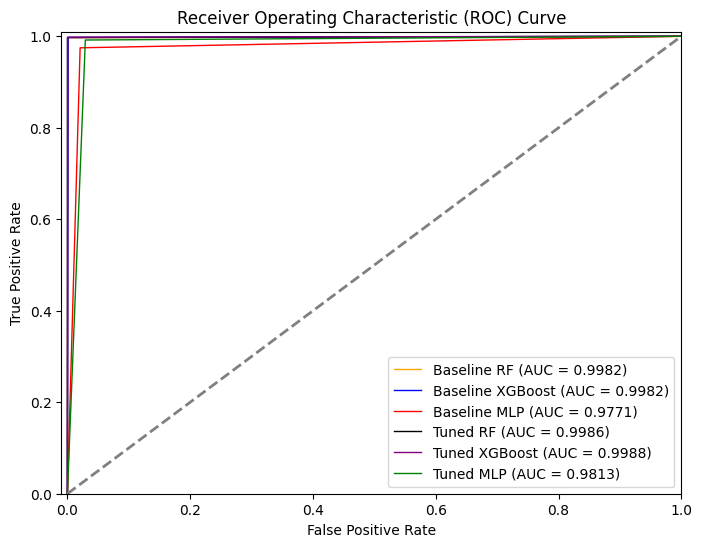

In [ ]:
# Plotting multiple ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_test_rf, tpr_test_rf, color='orange', lw=1, label=f'Baseline RF (AUC = {roc_auc_test_rf:.4f})') # lw=1 sets the line thickness (higher value will result in a thicker line)
plt.plot(fpr_test_xgb, tpr_test_xgb, color='blue', lw=1, label=f'Baseline XGBoost (AUC = {roc_auc_test_xgb:.4f})')
plt.plot(fpr_test_mlp, tpr_test_mlp, color='red', lw=1, label=f'Baseline MLP (AUC = {roc_auc_test_mlp:.4f})')
plt.plot(fpr_loaded_rf_tuned, tpr_loaded_rf_tuned, color='black', lw=1, label=f'Tuned RF (AUC = {roc_auc_loaded_rf_tuned:.4f})')
plt.plot(fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned, color='purple', lw=1, label=f'Tuned XGBoost (AUC = {roc_auc_loaded_xgb_tuned:.4f})')
plt.plot(fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned, color='green', lw=1, label=f'Tuned MLP (AUC = {roc_auc_loaded_mlp_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--') # plotting the diagonal line
plt.xlim([-0.01, 1.0]) # setting limits for the x-axis
plt.ylim([0.0, 1.01]) # setting limits for the y-axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**STAGE 4: APPLICATION OF SHAP AND LIME**

*4a. SHAP - Global explanation*

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.9 MB/s eta 0:00:00


In [ ]:
# Loading the best model
loaded_best_xgb = joblib.load('/content/drive/My Drive/Colab Notebooks/CP2/best_xgb_model.pkl')

[12:45:33] WARNING: /workspace/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.



In [ ]:
# Creating a TreeSHAP explainer
shap_explainer = shap.TreeExplainer(loaded_best_xgb)

[12:45:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [ ]:
%%time

# Computing SHAP values for the tree explainer
shap_values = shap_explainer.shap_values(x_test)

CPU times: user 795 ms, sys: 0 ns, total: 795 ms
Wall time: 722 ms


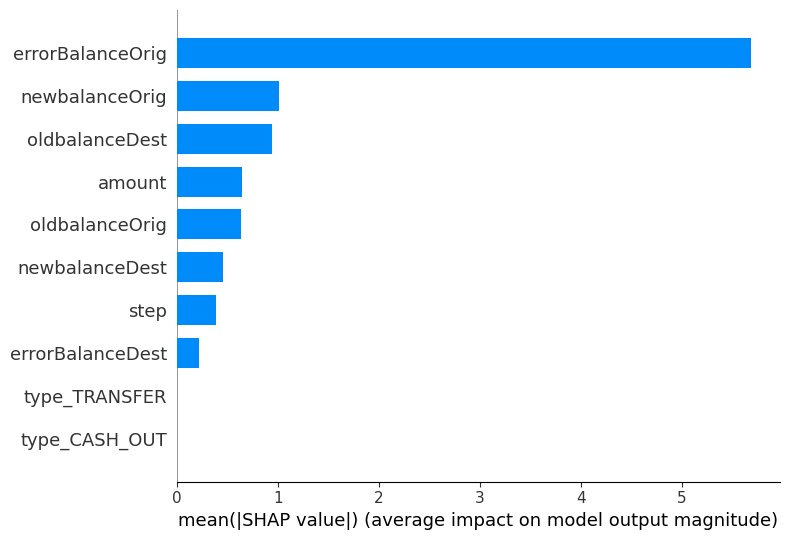

In [ ]:
# Generating SHAP global feature importance plot
shap.summary_plot(shap_values, x_test, plot_type="bar")

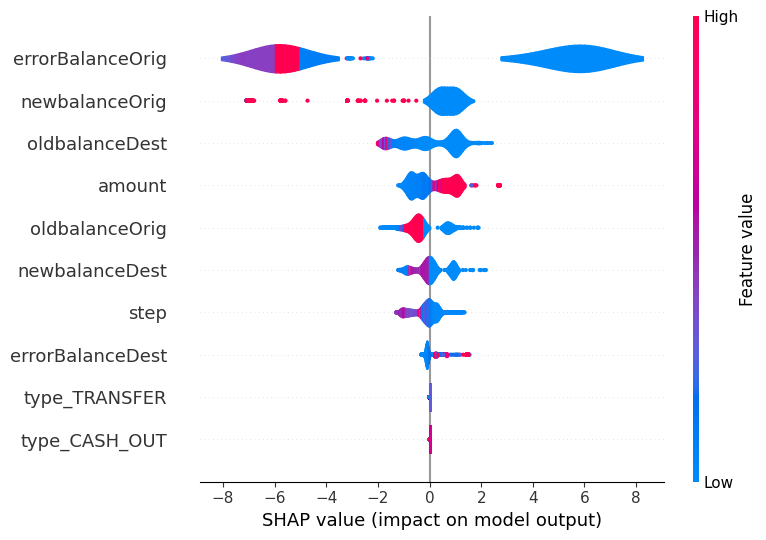

In [ ]:
# Generating SHAP summary plot
shap.summary_plot(shap_values, x_test, plot_type="violin")

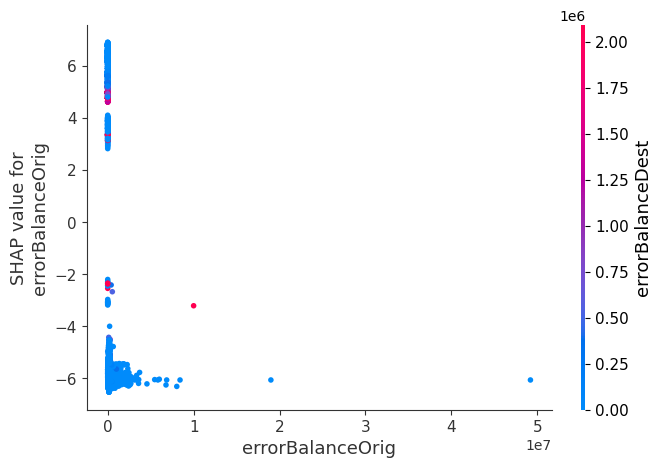

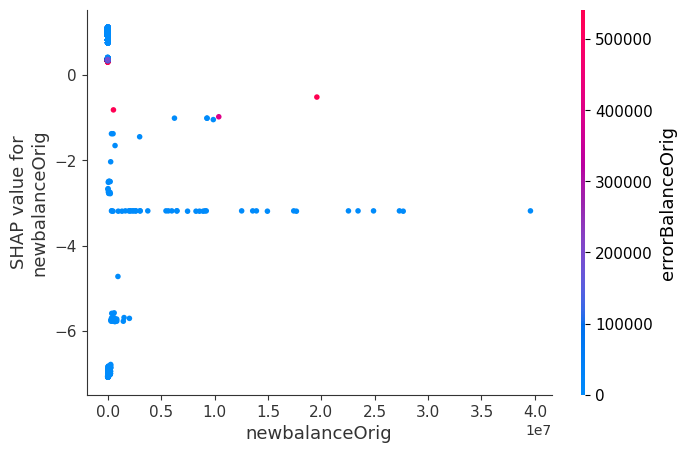

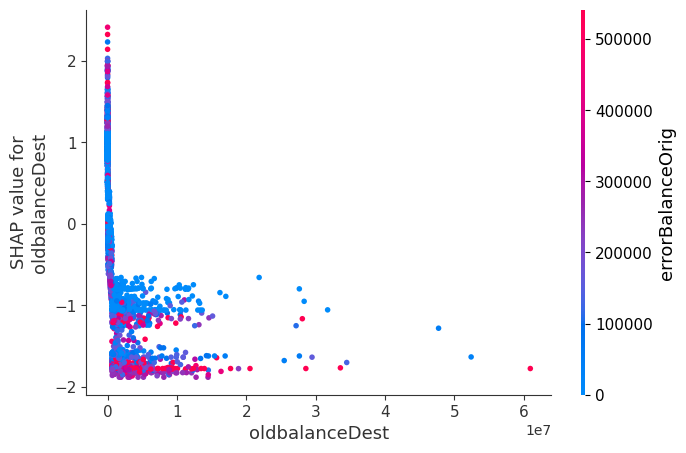

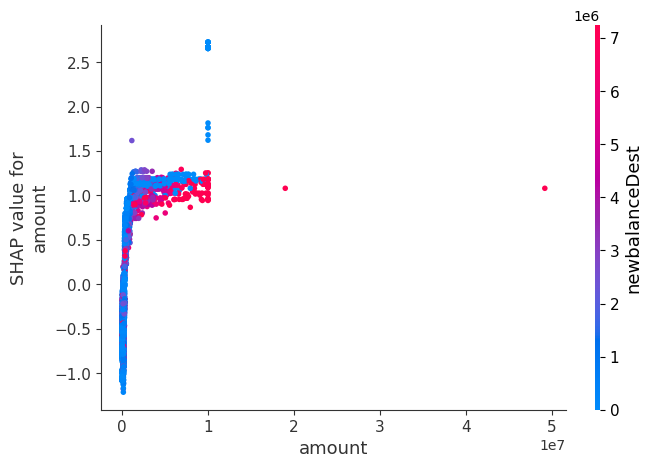

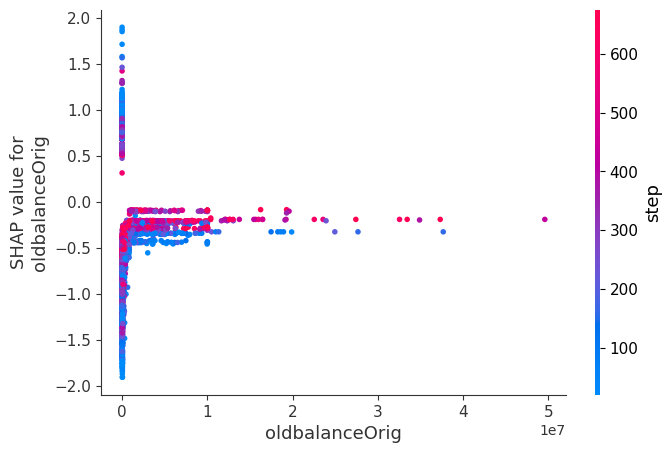

In [ ]:
# Generating SHAP feature interaction plot for the top 5 important features
shap.dependence_plot("errorBalanceOrig", shap_values, x_test, interaction_index="auto") # "auto" plots variables that exhibit the highest level of correlation with the variable specified
shap.dependence_plot("newbalanceOrig", shap_values, x_test, interaction_index="auto")
shap.dependence_plot("oldbalanceDest", shap_values, x_test, interaction_index="auto")
shap.dependence_plot("amount", shap_values, x_test, interaction_index="auto")
shap.dependence_plot("oldbalanceOrig", shap_values, x_test, interaction_index="auto")

*4b. SHAP - Local Explanation*

In [ ]:
# Creating a boolean mask where y_test = 0 (Genuine)
mask_genuine = (y_test == 0)

# Using the mask to filter indices in x_test
indices_y_0 = x_test.index[mask_genuine][:5]

# Printing the resulting indices
print("First 5 indices where transaction is genuine:", indices_y_0)

First 5 indices where transaction is genuine: Int64Index([3028971, 114803, 5295177, 6026282, 3713758], dtype='int64')


In [ ]:
df_balanced.loc[[114803]]

step   amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
114803    11  9388.22             0.0             0.0       303170.69             0.0        0           9388.22         312558.91              1              0

In [ ]:
# Accessing the row with index 114803 in x_test
x_test.loc[[114803]]

step   amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
114803    11  9388.22             0.0             0.0       303170.69             0.0           9388.22         312558.91              1              0

In [ ]:
# Accessing the target value for index 114803 in y_test
y_test.loc[[114803]]

114803    0
Name: isFraud, dtype: int64

In [ ]:
# Generating a local SHAP explanation for the legitimate instance
instance_leg = x_test.loc[[114803]] # selecting a specific row by index and storing it in a DataFrame
shap_value_1 = shap_explainer.shap_values(instance_leg) # calculates shap values for the instance
shap.initjs() # initializing JavaScript support for SHAP
shap.force_plot(shap_explainer.expected_value, # calculates average or baseline model prediction
                shap_value_1[0], # shap values for the given instance
                instance_leg)

In [ ]:
# Creating a boolean mask where y_test = 1 (Fraudulent)
mask_fraud = (y_test == 1)

# Using the mask to filter indices in x_test
indices_y_1 = x_test.index[mask_fraud][:5]

# Printing the resulting indices
print("First 5 indices where transaction is fraudulent:", indices_y_1)

First 5 indices where transaction is fraudulent: Int64Index([5010003, 6338605, 3960298, 6065301, 5769250], dtype='int64')


In [ ]:
df_balanced.loc[[6338605]]

step      amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
6338605   691  1518718.03      1518718.03             0.0             0.0      1518718.03        1               0.0               0.0              1              0

In [ ]:
# Accessing the row with index 6338605 in x_test
x_test.loc[[6338605]]

step      amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
6338605   691  1518718.03      1518718.03             0.0             0.0      1518718.03               0.0               0.0              1              0

In [ ]:
# Accessing the target value for index 6338605 in y_test
y_test.loc[[6338605]]

6338605    1
Name: isFraud, dtype: int64

In [ ]:
# Generating a local SHAP explanation for the fraudulent instance
instance_fraud = x_test.loc[[6338605]] # selecting a specific row by index and storing it in a DataFrame
shap_value_2 = shap_explainer.shap_values(instance_fraud) # calculates shap values for the instance
shap.initjs() # initializing JavaScript support for SHAP
shap.force_plot(shap_explainer.expected_value, # calculates average or baseline model prediction
                shap_value_2[0], # shap values for the given instance
                instance_fraud)

In [ ]:
# Generating a local SHAP explanation for the fraudulent instance for the 2nd time to evaluate for consistency
instance_fraud_2 = x_test.loc[[6338605]]
shap_value_2a = shap_explainer.shap_values(instance_fraud_2)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_value_2a[0], instance_fraud_2)

*4c. LIME*

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=54dc4d7742ad8ebeb64200a5c36f78f4ca97f1f1b4ff80aa129fe496a671b74e
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
%%time

# Creating a LIME explainer for explaining predictions on a tabular dataset
import lime
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_test.values, mode="classification", feature_names=x_test.columns, class_names=['Legitimate','Fraud'])

CPU times: user 20.7 ms, sys: 0 ns, total: 20.7 ms
Wall time: 26.8 ms


In [ ]:
# Defining the prediction function using the tuned XGBoost model to generate probability predictions
predict_function = lambda x: loaded_best_xgb.predict_proba(x).astype(float)

In [ ]:
class_name_mapping = {0: 'Legitimate', 1: 'Fraud'} # mapping class labels to their corresponding names

predicted_class = loaded_best_xgb.predict(x_test.loc[[114803]]) # predicted class label for the instance using the best model
actual_class = y_test[114803] # actual class label for the instance

print("Predicted class: ", class_name_mapping[predicted_class[0]]) # displaying the predicted class label using the class mapping dictionary
print("Actual class:    ", class_name_mapping[actual_class]) # displaying the actual class label using the class mapping dictionary

# Generating a LIME explanation for the legitimate instance by passing the predict_function
chosen_instance_1 = x_test.loc[[114803]].values[0] # converting instance into a Numpy array to extract its feature values
exp1 = lime_explainer.explain_instance(chosen_instance_1, predict_function)
exp1.show_in_notebook() # displaying the explanation in a notebook

Predicted class:  Legitimate
Actual class:     Legitimate


In [ ]:
predicted_class_2 = loaded_best_xgb.predict(x_test.loc[[6338605]]) # predicted class label for the instance using the best model
actual_class_2 = y_test[6338605] # actual class label for the instance

print("Predicted class: ", class_name_mapping[predicted_class_2[0]]) # displaying the predicted class label using the class mapping dictionary
print("Actual class:    ", class_name_mapping[actual_class_2]) # displaying the actual class label using the class mapping dictionary

# Generating a LIME explanation for the fraudulent instance by passing the predict_function
chosen_instance_2 = x_test.loc[[6338605]].values[0] # converting instance into a Numpy array to extract its feature values
exp2 = lime_explainer.explain_instance(chosen_instance_2, predict_function)
exp2.show_in_notebook() # displaying the explanation in a notebook

Predicted class:  Fraud
Actual class:     Fraud


In [ ]:
print("Predicted class: ", class_name_mapping[predicted_class_2[0]])
print("Actual class:    ", class_name_mapping[actual_class_2])

# Generating a LIME explanation for the fraudulent instance using the predict_function for the 2nd time to evaluate for consistency
exp2a = lime_explainer.explain_instance(chosen_instance_2, predict_function)
exp2a.show_in_notebook()

Predicted class:  Fraud
Actual class:     Fraud
